Se entrena a la red neuronal, que luego se utilizará para seguir la trayectoria. Se utiliza Tensorflow

In [2]:
import tensorflow as tf

import numpy as np

from google.colab import files

import matplotlib.pyplot as plt

import pdb

In [ ]:
print(tf.__version__)

In [ ]:
tf.keras.backend.clear_session()  # Para restablecer fácilmente el estado del portátil.

In [11]:
!rm -rf saved_models

In [ ]:
!pip install keras==2.6.0
!pip install tensorflow==2.6.0

In [12]:
npz_trayectorias = np.load('trayectorias_ref_deseada.npz')

keys = npz_trayectorias.files

Tr = npz_trayectorias[keys[0]]
Td = npz_trayectorias[keys[1]]

N = Tr.shape[1]

In [ ]:
# NO USAR ESTA CELDA!

# parámetro que indica cuántas entradas tendrá la red neuronal.
# en total tendrá 3*(L+1) entradas y 2 salidas

L = 1

i = 0

# lista donde se irán guardando las entradas de la red neuronal
DNN_inputs = []

# lista donde se irán guardando las salidas deseadas de la red neuronal
DNN_outputs = []

while (i+1+L < N):
    
    
    a = Tr[:,i:i+1+L]
    b = Td[:,i]
    
    DNN_inputs.append(a)
    DNN_outputs.append(b)
    
    i += 1

M = len(DNN_inputs)

# Una vez que terminé, genero los vectores columna de entrada para la red
# neuronal. Cada entrada de la red neuronal es un vector de 
# 3*(L+1) filas x 1 columna. Se genera una matriz "X" de 
# 3*(L+1) filas x M columnas.

aux = DNN_inputs[0]
X = np.reshape(aux.T,(3*(L+1),1))

aux = DNN_outputs[0]
Y = np.reshape(aux,(2,1))

for j in range(1,M):
    
    aux = DNN_inputs[j]
    x = np.reshape(aux.T,(3*(L+1),1))
    
    X = np.hstack((X,x))
    
    aux = DNN_outputs[j]
    y = np.reshape(aux,(2,1))
    Y = np.hstack((Y,y))

# patrones de entrada para la red
X = X.T

# salidas deseadas de la red
Y = Y.T

# dimensiones de entrada
N_input = X.shape[1]

# dimensiones de salida
N_output = Y.shape[1]

# neuronas de la capa oculta
N_middle = 1024

In [ ]:
# ESTA ES LA CELDA QUE HAY QUE USAR!
# Esta celda es para el caso con la referencia adelantada

trayectoria_recorrida = Tr.T
trayectoria_referencia = Td.T

i = 0

L = 2

DNN_inputs = []
DNN_outputs = []

while (i+1+L <= N):
    # pdb.set_trace()
    a = trayectoria_recorrida[i:i+L+1]
    a.shape = (3*(L  + 1),)
    b = trayectoria_referencia[i+1]

    DNN_inputs.append(a)
    DNN_outputs.append(b)

    i+=1

M = len(DNN_inputs)

X = DNN_inputs[0]

Y = DNN_outputs[0]

for j in range(1,M):
    aux = DNN_inputs[j]
    X = np.vstack((X,aux))

    aux = DNN_outputs[j]
    Y = np.vstack((Y,aux))

# dimensiones de entrada
N_input = X.shape[1]

# dimensiones de salida
N_output = Y.shape[1]

# neuronas de la capa oculta
N_middle = 1024

In [ ]:
Tr[:,35]

In [13]:
# ESTA CELDA LE SUMA +2*PI A TODOS PARÁMETROS ÁNGULO. ESTO ES PARA TENER SIEMPRE VALORES DE ÁNGULOS POSITIVOS, ENTRE 0 Y 2 PI.
# Esta celda es para el caso con la referencia adelantada

trayectoria_recorrida = Tr.T
trayectoria_referencia = Td.T

i = 0

L = 2

DNN_inputs = []
DNN_outputs = []

while (i+1+L <= N):
    # pdb.set_trace()
    a = np.copy(trayectoria_recorrida[i:i+L+1])
    a[:,2] = a[:,2] + 2*np.pi
    a.shape = (3*(L  + 1),)
    b = np.copy(trayectoria_referencia[i+1])

    DNN_inputs.append(a)
    DNN_outputs.append(b)

    i+=1

M = len(DNN_inputs)

X = DNN_inputs[0]

Y = DNN_outputs[0]

for j in range(1,M):
    aux = np.copy(DNN_inputs[j])
    X = np.vstack((X,aux))

    aux = np.copy(DNN_outputs[j])
    Y = np.vstack((Y,aux))

# dimensiones de entrada
N_input = X.shape[1]

# dimensiones de salida
N_output = Y.shape[1]

# neuronas de la capa oculta
N_middle = 5000

In [ ]:
X.shape

In [ ]:
X[0,:]

In [ ]:
Y[0,:]

In [14]:
# Creo la Red Neuronal
model = tf.keras.Sequential()

capas_ocultas = 1

# Capa de entrada
model.add(tf.keras.Input(shape=(N_input,)))

# Una capa oculta con inicialización de "glorot uniform". Este inicializa los
# pesos de cada neurona como una uniforme entre [-x, +x], donde x es:
#
# x = sqrt(6/(entradas + salidas))
# entradas es la cantidad de entradas a la reurona
# salidas es la cantidad de salidas de la neurona

model.add(tf.keras.layers.Dense(N_middle,
                                activation = 'relu',
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'glorot_uniform'))

model.add(tf.keras.layers.Dropout(0.5))


model.add(tf.keras.layers.Dense(N_output,
                                activation = 'linear',
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'glorot_uniform'))


# inicialización de cada neurona como una variabe aleatoria entre [-1, 1]
"""
initializer = tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5)

model.add(tf.keras.layers.Dense(N_middle,
                                activation = 'relu',
                                kernel_initializer = initializer,
                                bias_initializer = 'glorot_uniform'))

model.add(tf.keras.layers.Dropout(0.5))


model.add(tf.keras.layers.Dense(N_output,
                                activation = 'linear',
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'glorot_uniform'))
"""
eta = 0.0003

opt = tf.keras.optimizers.Adam(learning_rate = eta)
model.compile(optimizer = opt,
              loss = 'mse')

In [ ]:
np.std(model.layers[0].weights[0][:,:])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5000)              50000     
                                                                 
 dropout_1 (Dropout)         (None, 5000)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 10002     
                                                                 
Total params: 60,002
Trainable params: 60,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
model.layers[0].get_config()

In [16]:
# Se entrena la red neuronal

# history = model.fit(X,Y, epochs = 4000, batch_size = 30, validation_split=0.1)
history = model.fit(X,Y, epochs = 4000, batch_size = 30, shuffle = True)
# history = model.fit(X,Y, epochs = 4000, batch_size = 30, shuffle = False)

# history = model.fit(X,Y, epochs = 4000, batch_size = 30, validation_split=0.1, callbacks=[es])

Se truncaron las últimas líneas 5000 del resultado de transmisión.
2/2 [==============================] - 0s 10ms/step - loss: 0.7487
Epoch 1502/4000
2/2 [==============================] - 0s 9ms/step - loss: 0.5423
Epoch 1503/4000
2/2 [==============================] - 0s 8ms/step - loss: 0.7466
Epoch 1504/4000
2/2 [==============================] - 0s 8ms/step - loss: 0.6334
Epoch 1505/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.7363
Epoch 1506/4000
2/2 [==============================] - 0s 9ms/step - loss: 0.8447
Epoch 1507/4000
2/2 [==============================] - 0s 8ms/step - loss: 0.8279
Epoch 1508/4000
2/2 [==============================] - 0s 8ms/step - loss: 0.6607
Epoch 1509/4000
2/2 [==============================] - 0s 9ms/step - loss: 0.5363
Epoch 1510/4000
2/2 [==============================] - 0s 11ms/step - loss: 0.5873
Epoch 1511/4000
2/2 [==============================] - 0s 11ms/step - loss: 0.5953
Epoch 1512/4000
2/2 [======================

Text(0.5, 1.0, 'hidden = 1, units = 5000, Adam, L = 2, act = ReLu, eta = 0.0003')

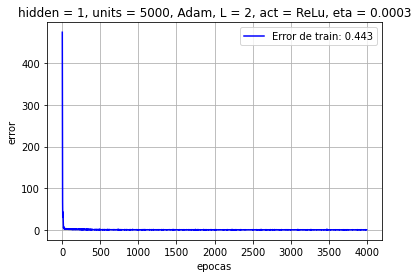

In [17]:
# se grafica el error vs época
# capas_ocultas = 1
# eta = 0.0003

N_loss = len(history.history['loss'])
# N_val_loss = len(history.history['val_loss'])

fig, ax = plt.subplots(1)
ax.plot(history.history['loss'],'b-',label = 'Error de train: %.3f' %(history.history['loss'][N_loss - 1]))
# ax.plot(history.history['val_loss'],'r-',label = 'Error de test: %.3f' %(history.history['val_loss'][N_val_loss - 1]))

ax.set_xlabel('epocas')
ax.set_ylabel('error')
ax.legend()
ax.grid(True)
ax.set_title('hidden = %i, units = %i, Adam, L = %i, act = ReLu, eta = %.4f' %(capas_ocultas, N_middle, L, eta))

In [9]:
fig.savefig('entrenamiento_L.png',dpi = 300)

In [18]:
# Se exporta el modelo para después utilizarlo

tf.keras.models.save_model(model,"./saved_models")

# Se descarga el modelo para cargarlo en otro notebook
!zip -r /content/file.zip /content/saved_models
files.download("/content/file.zip")

INFO:tensorflow:Assets written to: ./saved_models/assets
updating: content/saved_models/ (stored 0%)
updating: content/saved_models/keras_metadata.pb (deflated 85%)
updating: content/saved_models/variables/ (stored 0%)
updating: content/saved_models/variables/variables.index (deflated 57%)
updating: content/saved_models/variables/variables.data-00000-of-00001 (deflated 26%)
updating: content/saved_models/assets/ (stored 0%)
updating: content/saved_models/saved_model.pb (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('./tmp/model')
# Se descarga el modelo para cargarlo en otro notebook
!zip -r /content/file.zip /content/tmp/model
files.download("/content/file.zip")

In [ ]:
# Se importa el modelo del archivo "file.zip"
!unzip "/content/file.zip" -d "/content/output_folder"

In [ ]:
model = tf.keras.models.load_model("./output_folder/content/saved_models", compile = True)

In [ ]:
for k in range(0,49):

  current = X[k,0:2]

  reference = model.predict(np.expand_dims(X[k,:], axis = 0))

  reference.shape = (2,)

  print( np.linalg.norm(reference - current) )


In [ ]:
reference

array([20.048134, 22.13471 ], dtype=float32)